# Federated Learning: Create Multi-Armed Bandit


In [1]:
%load_ext autoreload
%autoreload 2

import syft as sy
from syft.serde import protobuf
from syft_proto.execution.v1.plan_pb2 import Plan as PlanPB
from syft_proto.execution.v1.state_pb2 import State as StatePB
from syft.grid.clients.static_fl_client import StaticFLClient
from syft.execution.state import State
from syft.execution.placeholder import PlaceHolder
from syft.execution.translation import TranslationTarget

import torch as th
from torch import nn

import os
import websockets
import json
import requests

sy.make_hook(globals())
hook.local_worker.framework = None
th.random.manual_seed(1)

Setting up Sandbox...
Done!


rand_rates [0.7972945811825113, 0.12725788876634408, 0.3201556479593157, -0.0029781043749466897, 0.49562148945629675, 0.79584533032818, 0.18949381705692833, 0.5096397152251275, 0.23665674638680387, 0.7910362749759409, 0.7310701868312672, 0.6097581800621372, 0.11483152714163904, 0.2574500550444083, 0.16628624148199886, 0.014699913824273804, 0.6255188226506538, 0.5266600072477414, 0.0988753353827694, 0.156326035576045, 0.7980191450045245, 0.4109298242426678, 0.3584262106298323, 0.10842460366167118]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 24
0
samples_from_beta_distr {0: 0.7608301288441672, 1: 0.15311159067657942, 2: 0.9414826863401758, 3: 0.5051116681855029, 4: 0.24471608111191462, 5: 0.5297854338047981, 6: 0.5640665098758832, 7: 0.15227045386441507, 8: 0.4551865861684395, 9: 0.8857173410320769, 10: 0.26999426881166916, 11: 0.7620094055655834, 12: 0.15245172659892306, 13: 0.06804434301134031, 14: 0.913938360

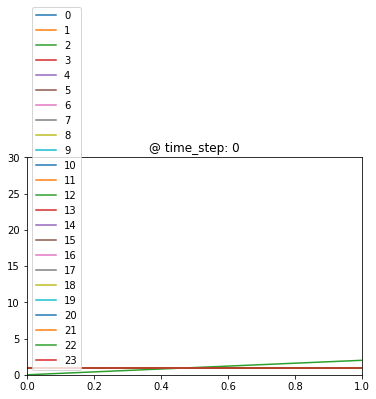

1
samples_from_beta_distr {0: 0.4771059613145126, 1: 0.09926160349196471, 2: 0.9664786348753517, 3: 0.8291881788307723, 4: 0.598180387718662, 5: 0.04882514226922373, 6: 0.8469613590594623, 7: 0.8473870881587565, 8: 0.42200232495965817, 9: 0.09219542301517275, 10: 0.9075750095915114, 11: 0.7650098014773188, 12: 0.11101505925479364, 13: 0.5010807431557462, 14: 0.046885191965875095, 15: 0.023004568709786635, 16: 0.20567968182680324, 17: 0.8246309824657294, 18: 0.49128762778458906, 19: 0.28279762020992416, 20: 0.8315594731229975, 21: 0.709116723258311, 22: 0.6286545624152894, 23: 0.029914106372567664}
selected action:  2 rwd:  0
updated rewd vec:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
time_step:  1 new params:  tensor([1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.]) tensor([1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       

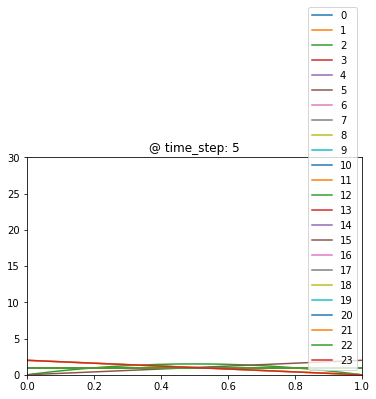

6
samples_from_beta_distr {0: 0.3751004306386427, 1: 0.11631628674623835, 2: 0.6283738252517936, 3: 0.6456531431801448, 4: 0.6268960707542386, 5: 0.5321797546808402, 6: 0.9829649134934988, 7: 0.4308430596883361, 8: 0.013330265662302882, 9: 0.538711359348354, 10: 0.3507236526545338, 11: 0.3325801932352531, 12: 0.4437570603354956, 13: 0.8385733074075712, 14: 0.4805850728289174, 15: 0.13727665637535666, 16: 0.3108402480593622, 17: 0.3370630661342745, 18: 0.7892770973917633, 19: 0.12766896631274108, 20: 0.5442026410657466, 21: 0.5682183306915164, 22: 0.5949648593090205, 23: 0.18265832360820788}
selected action:  6 rwd:  0
updated rewd vec:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
time_step:  6 new params:  tensor([1., 1., 2., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.]) tensor([1., 2., 2., 1., 1., 1., 2., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.

ValueError: Domain error in arguments.

In [2]:
import scipy.stats as ss
from IPython.display import clear_output
from IPython import display
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import bernoulli
import random

num_possibilities = 24

def draw_plot(_alpha_beta, time_step=8888):
    fig = plt.figure()
    fig.canvas.draw()
    plt.xlim(0,1)
    x = np.linspace(0, 1, 100)
    tempy = []

    for idx in range(len(_alpha_beta[0])):
        a = _alpha_beta[0][idx]
        b = _alpha_beta[1][idx]
        y = ss.beta.pdf(x, a,b)
        plt.plot(x,y,label=idx)

    plt.ylim(0,30)
    plt.legend()
    plt.title('@ time_step: {}'.format(time_step))
    display.display(plt.gcf())

class simulator():
    def __init__(self, slots=[.1, .6, .8]):
        self.slots = slots
        self.action_space = list(range(len(slots)))

    def simulate(self, slot_idx):
        return bernoulli.rvs(self.slots[slot_idx]) 

    def simulate_ui(self, slot_idx):
        rwd = input(f'displaying with UI config {slot_idx} out of {len(self.slots)} options, input 1 for click 0 for no')
        return rwd

rand_rates = [min(random.random(), .8) - (random.random() / 100) for iter in range(num_possibilities)]

print('rand_rates', rand_rates)

env = simulator(rand_rates)
env.action_space

def run_simulation(n):
    _one_vec= [1.0] * num_possibilities
    _blank_vec= [0.0] * num_possibilities
    alphas = th.tensor(_one_vec, requires_grad=False)
    betas = th.tensor(_one_vec, requires_grad=False)

    samples_from_beta_distr = {}
    time_step = 0

    for x in range(n):
        print(x)
        rwd_vec = _blank_vec[:]
        sampled_vec = _blank_vec[:]
        for k in range(num_possibilities):#env.action_space:
            samples_from_beta_distr[k] = np.random.beta(alphas[k], betas[k])

        print('samples_from_beta_distr', samples_from_beta_distr)

        selected_action = max(samples_from_beta_distr, key=samples_from_beta_distr.get)
        reward = env.simulate(selected_action)
        time_step += 1

        print('selected action: ', selected_action, 'rwd: ',  reward)

        rwd_vec[selected_action] = float(reward)
        sampled_vec[selected_action] = 1

        print('updated rewd vec: ', rwd_vec)

        (alphas, betas) = bandit_thompson(th.tensor(rwd_vec),th.tensor(sampled_vec), alphas, betas)

        print('time_step: ', x, 'new params: ', alphas, betas)

        if x % 5 == 0:
            draw_plot((alphas, betas), x)

    return (alphas, betas)

''' thompson sampling bandit '''
# the first elem of alpha_beta is the alpha parameter for a beta distr for i-th option where i = index
# the 2nd elem of alpha_beta is the beta parameter ... 
# alphabeta will never be more than 2 elements but each alpha and beta vector could have more elements if we have more options
# this organization allows us to do vectorized updating of the params

_blank_vec= [0.0] * num_possibilities
_one_vec = [1.0] * num_possibilities

print(_blank_vec, len(_blank_vec))

alphas = th.tensor(_one_vec, requires_grad=False)
betas = th.tensor(_one_vec, requires_grad=False)

rwd = th.tensor(_blank_vec)
samples = th.tensor(_blank_vec)
bandit_args_th = [rwd, samples, alphas, betas]
bandit_th_args_shape = [rwd.shape, samples.shape, alphas.shape, betas.shape]

@sy.func2plan(args_shape=bandit_th_args_shape)
def bandit_thompson(reward, sample_vector, alphas, betas):
    prev_alpha = alphas
    prev_beta = betas

    alphas = prev_alpha.add(reward)
    betas = prev_beta.add(sample_vector.sub(reward))

    return (alphas, betas)
        
final_alphas, final_betas = run_simulation(20)

In [3]:
#sanity check
print(np.argmax(final_alphas), np.argmax(final_betas))
print(np.argmin(final_alphas), np.argmin(final_betas))

rand_rates[18]

NameError: name 'final_alphas' is not defined

## Step 3: Define Averaging Plan

Averaging Plan is executed by PyGrid at the end of the cycle,
to average _diffs_ submitted by workers and update the model
and create new checkpoint for the next cycle.

_Diff_ is the difference between client-trained
model params and original model params,
so it has same number of tensors and tensor's shapes
as the model parameters.

We define Plan that processes one diff at a time.
Such Plans require `iterative_plan` flag set to `True`
in `server_config` when hosting FL model to PyGrid.

Plan below will calculate simple mean of each parameter.

In [4]:
@sy.func2plan()
def avg_plan(avg, item, num):
    new_avg = []

    for i, param in enumerate(avg):
        new_avg.append((avg[i] * num + item[i]) / (num + 1))
        
    return new_avg

# Build the Plan
_ = avg_plan.build(bandit_args_th, bandit_args_th
, th.tensor([1.0]))

In [5]:
# Let's check Plan contents
print(avg_plan.code)

def avg_plan(arg_1, arg_2, arg_3, arg_4, arg_5, arg_6, arg_7, arg_8, arg_9):
    var_0 = arg_1.__mul__(arg_9)
    var_1 = var_0.__add__(arg_5)
    var_2 = arg_9.__add__(1)
    out_1 = var_1.__truediv__(var_2)
    var_3 = arg_2.__mul__(arg_9)
    var_4 = var_3.__add__(arg_6)
    var_5 = arg_9.__add__(1)
    out_2 = var_4.__truediv__(var_5)
    var_6 = arg_3.__mul__(arg_9)
    var_7 = var_6.__add__(arg_7)
    var_8 = arg_9.__add__(1)
    out_3 = var_7.__truediv__(var_8)
    var_9 = arg_4.__mul__(arg_9)
    var_10 = var_9.__add__(arg_8)
    var_11 = arg_9.__add__(1)
    out_4 = var_10.__truediv__(var_11)
    return out_1, out_2, out_3, out_4


In [6]:
# Test averaging plan
# Pretend there're diffs, all params of which are ones * dummy_coeffs
dummy_coeffs = [1, 5.5, 7, 55]
dummy_diffs = [[th.ones_like(param) * i for param in bandit_args_th] for i in dummy_coeffs]
mean_coeff = th.tensor(dummy_coeffs).mean().item()

# Remove original function to make sure we execute traced Plan
avg_plan.forward = None

# Calculate avg value using our plan
avg = dummy_diffs[0]

for i, diff in enumerate(dummy_diffs[1:]):
    avg = avg_plan(list(avg), diff, th.tensor([i + 1]))

# Avg should be ones*mean_coeff for each param
for i, param in enumerate(bandit_args_th):
    expected = th.ones_like(param) * mean_coeff
    assert avg[i].eq(expected).all(), f"param #{i}"

## Step 4: Host in PyGrid

Let's now host everything in PyGrid so that it can be accessed by worker libraries (syft.js, KotlinSyft, SwiftSyft, or even PySyft itself).

First, we need a function to send websocket messages to PyGrid.

In [7]:
async def sendWsMessage(data):
    async with websockets.connect('ws://' + gatewayWsUrl) as websocket:
        await websocket.send(json.dumps(data))
        message = await websocket.recv()
        return json.loads(message)

Follow PyGrid README.md to build `openmined/grid-gateway` image from the latest `dev` branch 
and spin up PyGrid using `docker-compose up --build`.

Define name, version, configs.

In [8]:
# Default gateway address when running locally 
gatewayWsUrl = "127.0.0.1:5000"
grid = StaticFLClient(id="test", address=gatewayWsUrl, secure=False)
grid.connect()

# These are the name/version you use in worker
name = "bandit"
version = "1.0.0"

client_config = {
    "name": name,
    "version": version,
    "batch_size": 64,
    "lr": 0.005,
    "max_updates": 100  # custom syft.js option that limits number of training loops per worker
}

server_config = {
    "min_workers": 1,
    "max_workers": 1,
    "pool_selection": "random",
    "do_not_reuse_workers_until_cycle": 20,
    "cycle_length": 28800,  # max cycle length in seconds
    "num_cycles": 200,  # max number of cycles
    "max_diffs": 1,  # number of diffs to collect before avg
    "minimum_upload_speed": 0,
    "minimum_download_speed": 0,
    "iterative_plan": True  # tells PyGrid that avg plan is executed per diff
}

In [9]:
model_params_state = State(
    state_placeholders=[
        PlaceHolder().instantiate(param)
        for param in bandit_args_th
    ]
)

response = grid.host_federated_training(
    model=model_params_state,
    client_plans={'training_plan': bandit_thompson},
    client_protocols={},
    server_averaging_plan=avg_plan,
    client_config=client_config,
    server_config=server_config
)

print("Host response:", response)

Host response: {'type': 'federated/host-training', 'data': {'status': 'success'}}


Make authentication request:

In [10]:
auth_request = {
    "type": "federated/authenticate",
    "data": {
        "model_name": name,
        "model_version": version,
    }
}

auth_response = await sendWsMessage(auth_request)

print('Auth response: ', json.dumps(auth_response, indent=2))

Auth response:  {
  "type": "federated/authenticate",
  "data": {
    "status": "success",
    "worker_id": "14bd369b-d36c-403f-95d6-a02047b03460"
  }
}


Make the cycle request:

In [11]:
cycle_request = {
    "type": "federated/cycle-request",
    "data": {
        "worker_id": auth_response['data']['worker_id'],
        "model": name,
        "version": version,
        "ping": 1,
        "download": 10,
        "upload": 10,
    }
}

cycle_response = await sendWsMessage(cycle_request)

print('Cycle response:', json.dumps(cycle_response, indent=2))

worker_id = auth_response['data']['worker_id']
request_key = cycle_response['data']['request_key']
model_id = cycle_response['data']['model_id'] 
training_plan_id = cycle_response['data']['plans']['training_plan']

Cycle response: {
  "type": "federated/cycle-request",
  "data": {
    "status": "accepted",
    "request_key": "1830495728f56968aa8db61be91130c50252215ed7513ef864d2967334772a01",
    "version": "1.0.1",
    "model": "bandit_th_24",
    "plans": {
      "training_plan": 2
    },
    "protocols": {},
    "client_config": {
      "name": "bandit_th_24",
      "version": "1.0.1",
      "batch_size": 64,
      "lr": 0.005,
      "max_updates": 100
    },
    "model_id": 1
  }
}


## Step 5: Train

To train hosted model, use the multi-armed bandit example in [syft.js](https://github.com/OpenMined/syft.js/tree/master/examples/multi-armed-bandit).